# MPI calibration: comparison between two experiments

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *

archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    experiment = os.path.splitext(os.path.basename(zip_name))[0]
    if 'smpi' not in experiment:
        experiment = 'real'
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

result = extract_zip(archive_name)
result_smpi_nosub_corrected = extract_zip('smpi_stochastic.zip')

In [2]:
# Special processing for the Pingpong dataset
for res in [result, result_smpi_nosub_corrected]:
    df = res['exp/exp_PingPong.csv']
    pingpong_send = df[df.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df[df.op=='MPI_Recv'].reset_index(drop=True)
    df = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration,
                       experiment = pingpong_send.experiment,
                  ))
    res['exp/exp_PingPong.csv'] = df
    res['exp_Send'] = pingpong_send

allresults = {}
for key in result_smpi_nosub_corrected.keys():
    if isinstance(result_smpi_nosub_corrected[key], pandas.DataFrame):
        allresults[key] = pandas.concat([
            result[key],
            result_smpi_nosub_corrected[key],
        ])

df_send = allresults['exp_Send']
df_isend = allresults['exp/exp_Isend.csv']
df_recv = allresults['exp/exp_Recv.csv']
df_wtime = allresults['exp/exp_Wtime.csv']
df_test = allresults['exp/exp_Test.csv']
df_iprobe = allresults['exp/exp_Iprobe.csv']
df_pingpong = allresults['exp/exp_PingPong.csv']

### MPI_Send

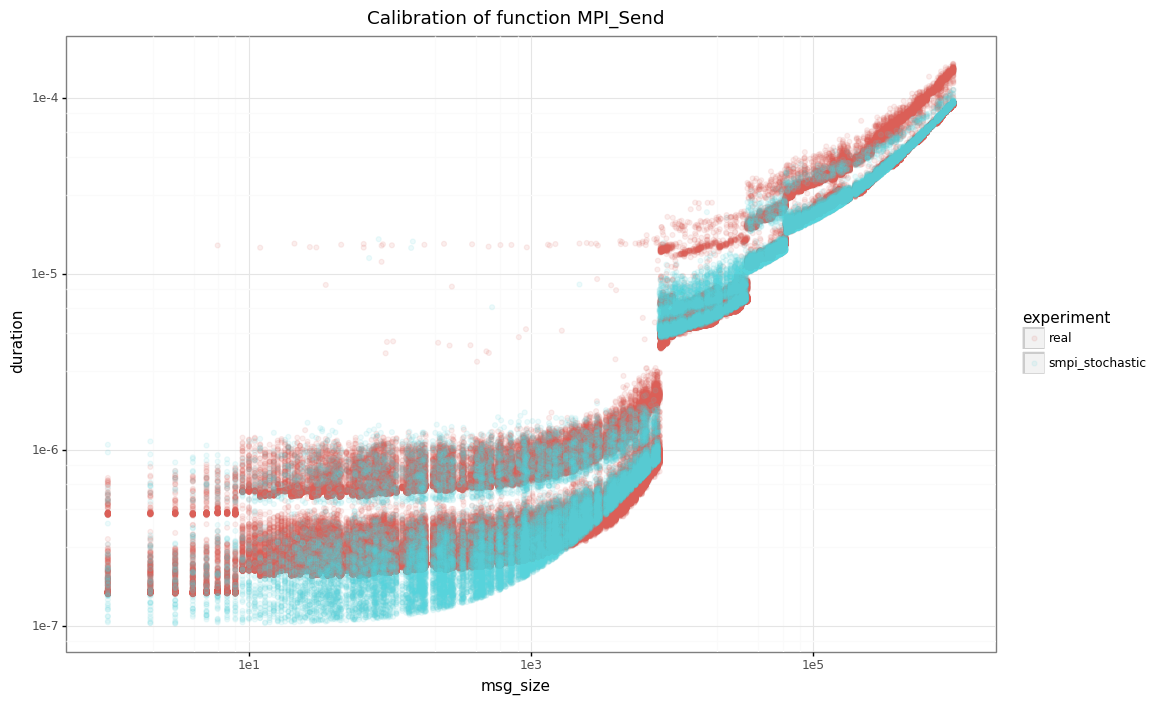

<ggplot: (-9223363275837846030)>


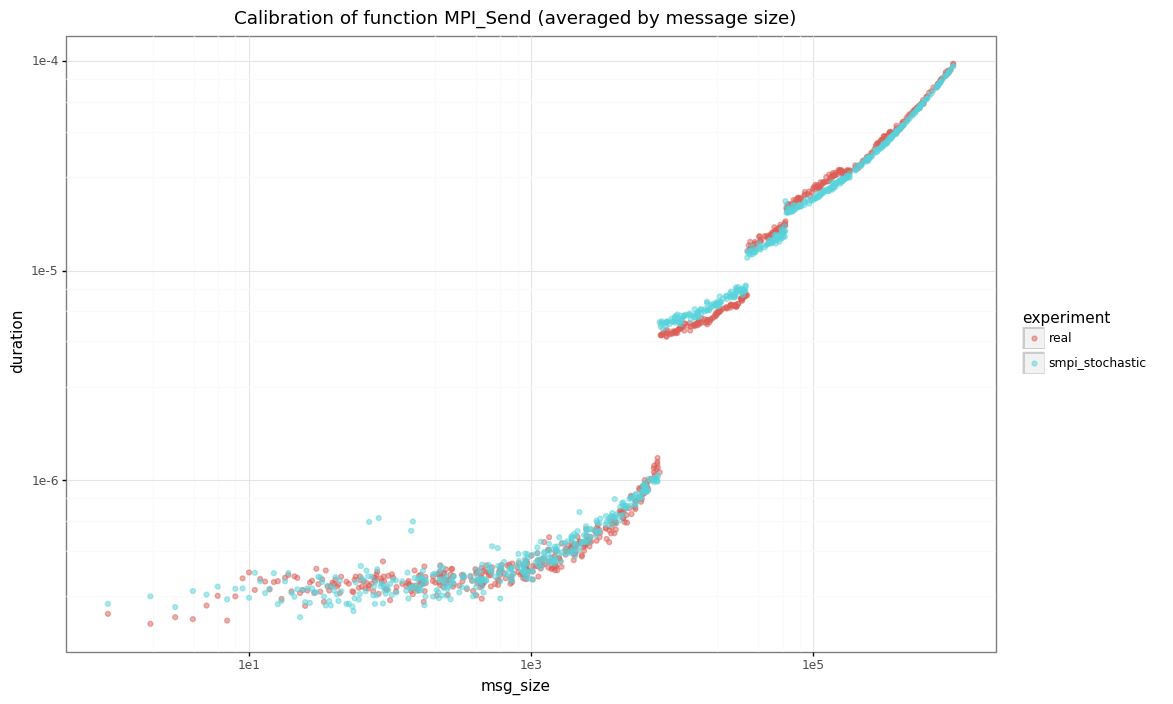

<ggplot: (-9223363275873799175)>


In [3]:
def plot(df):
    func = list(df['op'].unique())
    assert len(func) == 1
    func = func[0]
    plot = ggplot(df, aes(x='msg_size', y='duration', color='experiment')) + geom_point(alpha=0.1) + theme_bw()
    print(plot + scale_x_log10() + scale_y_log10() + ggtitle('Calibration of function %s' % func))
    aggr = df.groupby(['experiment', 'msg_size']).mean().reset_index()
    plot = ggplot(aggr, aes(x='msg_size', y='duration', color='experiment')) + geom_point(alpha=0.5) + theme_bw()
    print(plot + scale_x_log10() + scale_y_log10() + ggtitle('Calibration of function %s (averaged by message size)' % func))

plot(df_send)

### MPI_ISend

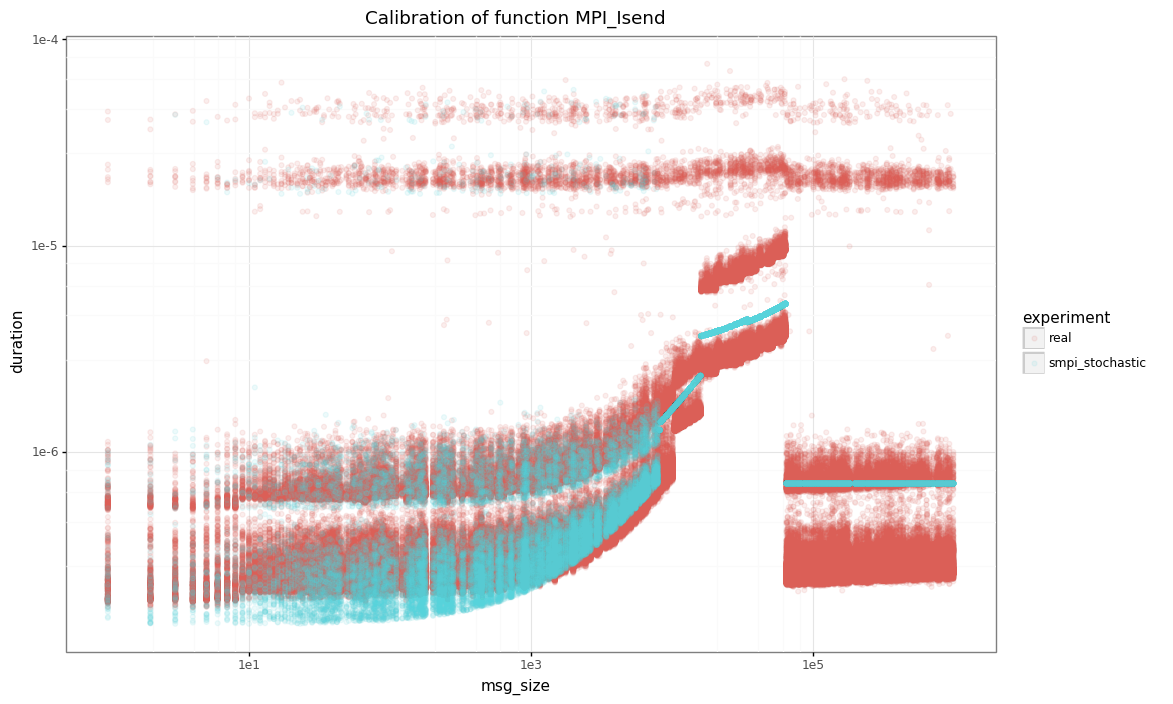

<ggplot: (8760972636452)>


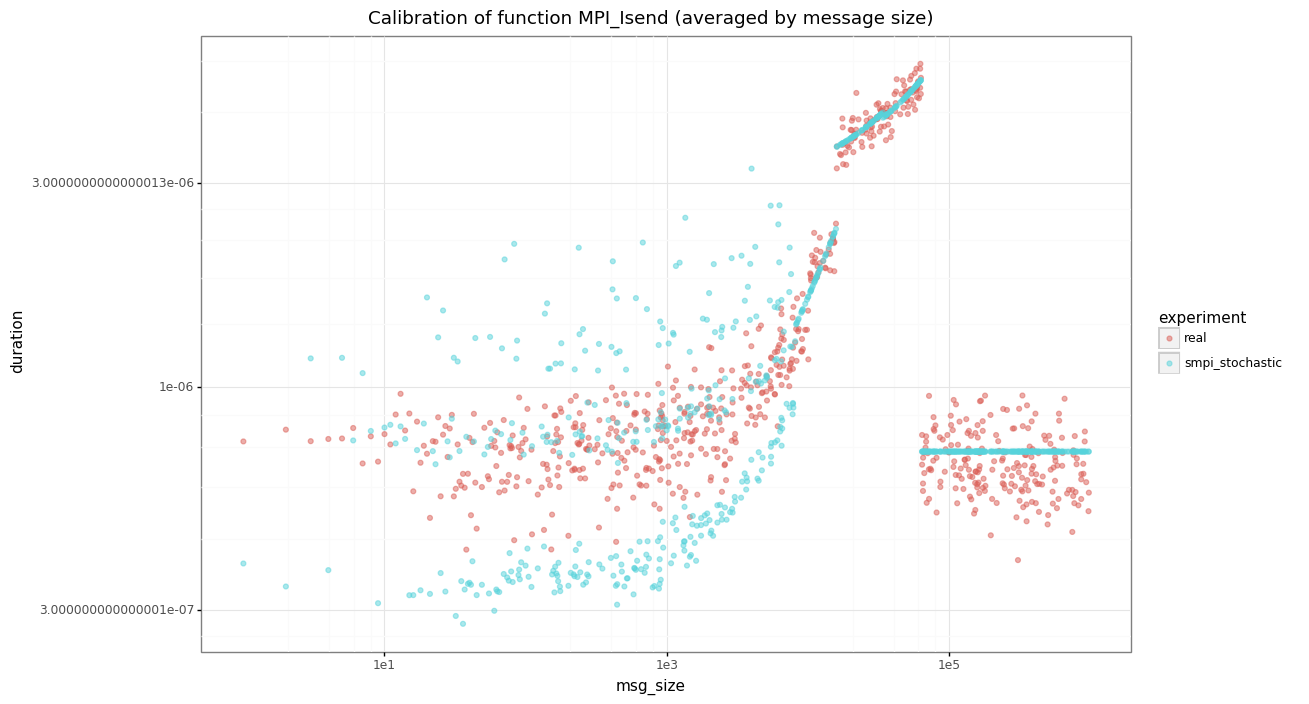

<ggplot: (8761016365821)>


In [4]:
plot(df_isend)

### MPI_Recv

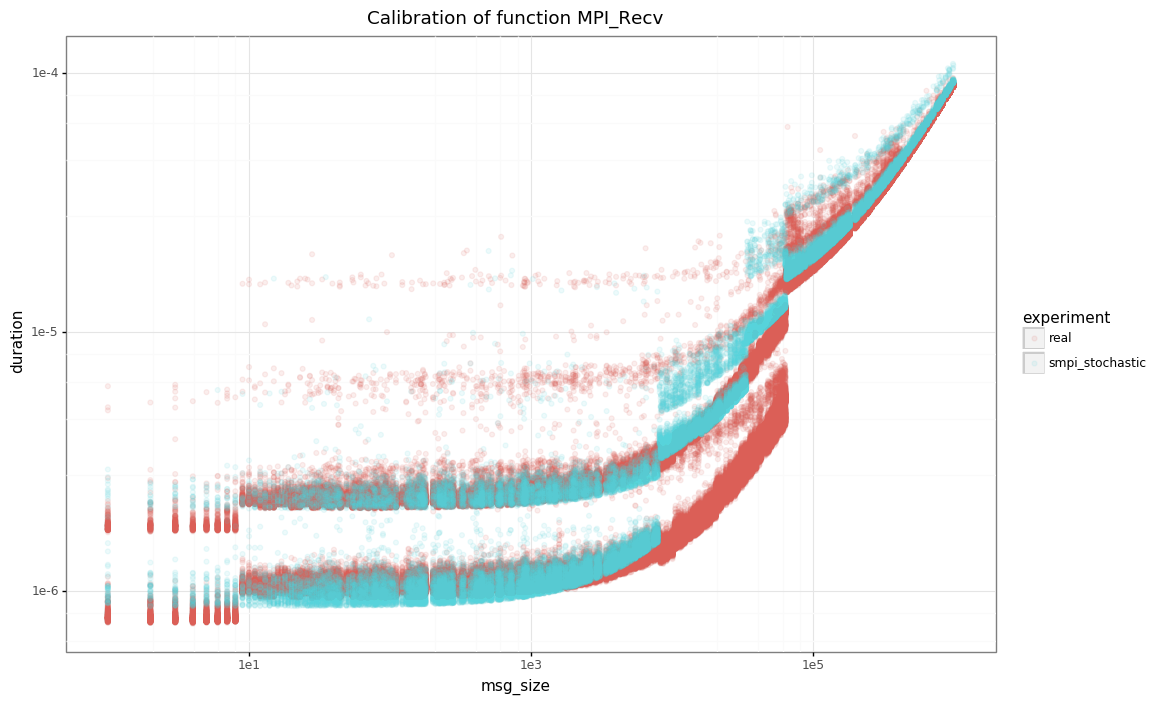

<ggplot: (8760980978517)>


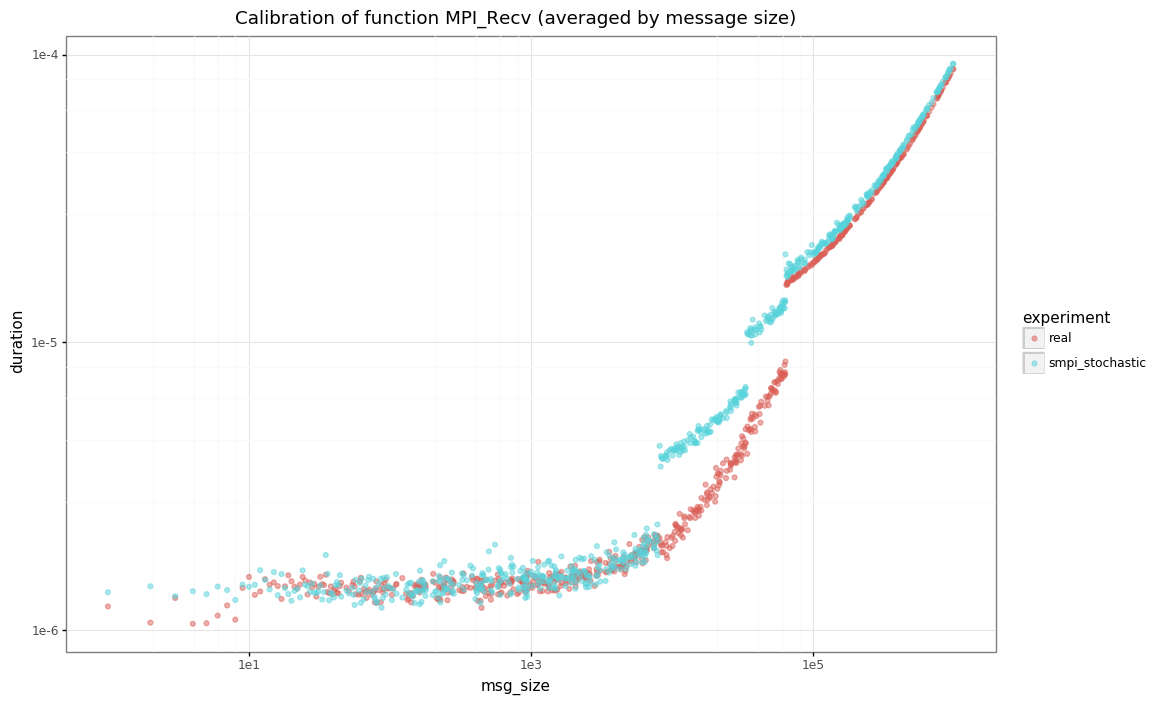

<ggplot: (-9223363275879927829)>


In [5]:
plot(df_recv)

### Pingpong

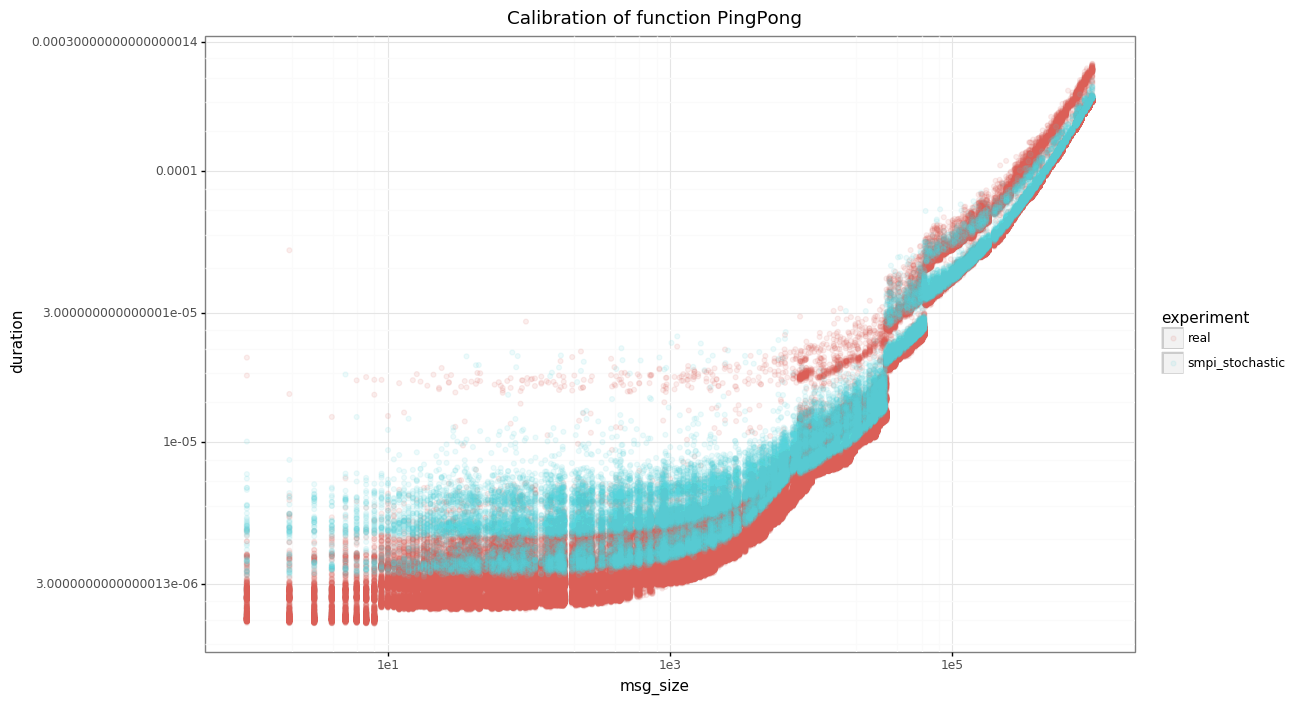

<ggplot: (-9223363275879936526)>


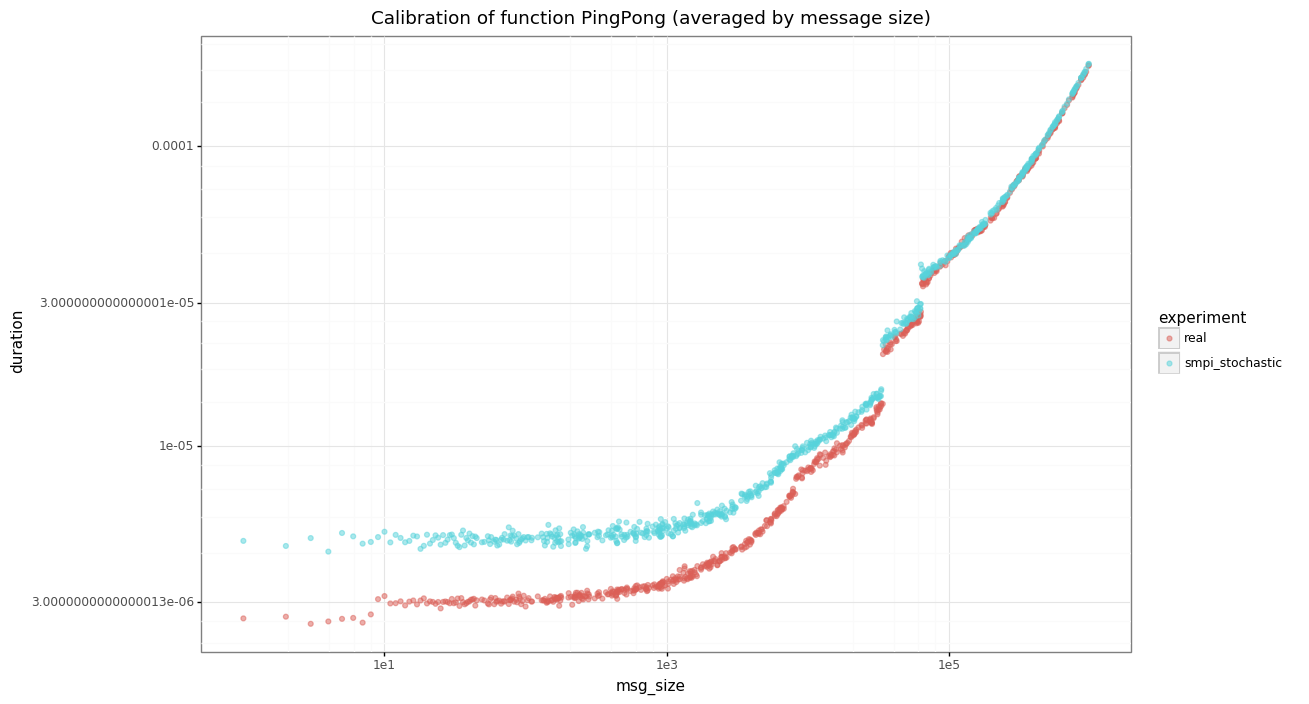

<ggplot: (8760980539407)>


In [6]:
plot(df_pingpong)